## Crystal system exploration

In [1]:
import tensorflow as tf

# Verificar si se está utilizando la GPU
if tf.test.gpu_device_name():
    print('GPU encontrada.')
else:
    print("No se encontró GPU. Se utilizará la CPU.")

# Librerias adicionales:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.linear_model import LinearRegression as LR

GPU encontrada.


In [2]:
directorio = 'C:/Users/marit/Documents/UPY Estancia I/latpar_project/LatPars_SuperModel/'

hfxrd = np.load(directorio + 'hf_0100.npy')
y = np.load('C:/Users/marit/Documents/UPY Estancia I/latpar_project/latpars.npy')

In [3]:
db = pd.read_csv('C:/Users/marit/Documents/UPY Estancia I/latpar_project/db_peaks.csv')

In [4]:
dftest = pd.read_csv(directorio + 'dftest.csv')
dftraval = pd.read_csv(directorio + 'dftraval.csv')

In [5]:
for row in range(db.shape[0]):    
    db.at[row,'name'] = db['name'][row][:7]

In [6]:
# !!!, checar esta cosa, no urge.
dftest = pd.read_csv(directorio + 'dftest.csv')
dftraval = pd.read_csv(directorio + 'dftraval.csv')

for row in range(dftest.shape[0]):
    dftest.at[row, 'name'] = dftest['name'][row][:7]
    
for row in range(dftraval.shape[0]):
    dftraval.at[row, 'name'] = dftraval['name'][row][:7]

ntest = dftest.shape[0]//4
ntraval = dftraval.shape[0]//4

dftest = dftest.iloc[:ntest,:].reset_index(drop=True)
dftraval = dftraval.iloc[:ntraval,:].reset_index(drop=True)

idxtraval = [i for i in db.loc[db.name.isin([i.split('_')[0] for i in dftraval.name.values])].index]
idxtest = [i for i in db.loc[db.name.isin([i.split('_')[0] for i in dftest.name.values])].index]

hftest = hfxrd[idxtest]
hftraval = hfxrd[idxtraval]

ytest = y[idxtest]
ytraval = y[idxtraval]

In [7]:
sgdiccio = pd.read_csv('C:/Users/marit/Documents/UPY Estancia I/latpar_project/sgnum_cif.csv')
sgdiccio = {k:v for k,v in zip(sgdiccio.cif.values, sgdiccio.sgnum.values)}

dbtest = db.take(idxtest).reset_index(drop=True)
dbtraval = db.take(idxtraval).reset_index(drop=True)

dbtest['sgnum'] = [sgdiccio.get(int(i), None) for i in dbtest.name.values]
dbtraval['sgnum'] = [sgdiccio.get(int(i), None) for i in dbtraval.name.values]

In [8]:
cs = dict()

for n in range(1,231):
    
    if n <= 2: cs[n]  = 0;
    elif 2 < n <=15: cs[n] = 1;
    elif 15 < n <=74: cs[n] = 2;
    elif 74 < n <=142: cs[n] = 3;
    elif 142 < n <=167: cs[n] = 4;
    elif 167 < n <=194: cs[n] = 5;
    elif 194 < n <=230: cs[n] = 6;

In [9]:
dbtest['cs'] = [cs.get(i, None) for i in dbtest.sgnum.values]
dbtraval['cs'] = [cs.get(i, None) for i in dbtraval.sgnum.values]

Orthogonal vectors for crystal systems

In [10]:
orthoset = scipy.stats.ortho_group.rvs(32, random_state=3451)
csos_test = orthoset[dbtest.cs.values]
csos_traval = orthoset[dbtraval.cs.values]

Orthogonal vectors for space groups

In [11]:
sgoset = scipy.stats.ortho_group.rvs(230, random_state=3451)
sgos_traval = sgoset[dbtraval.sgnum.values-1]
sgos_test = sgoset[dbtest.sgnum.values-1]

In order to shape our insights we will now use an nn to find the performance with each crystal systems

In [12]:
# !!!
def create_mlp(features = int, multiples = list, dropout = 0, name= 'multilayer_nn'):
    input_layer = tf.keras.Input((features))

    for n, hl in enumerate(multiples):

        if n == 0: x = tf.keras.layers.Dense(hl*features)(input_layer)
        else: x = tf.keras.layers.Dense(hl*features)(x)

        x = tf.keras.layers.LayerNormalization()(x)

        if n != len(multiples) -1:
            x = tf.keras.layers.LeakyReLU(0.15)(x)
            x = tf.keras.layers.Dropout(dropout)(x)

    xs = tf.keras.layers.Dense(multiples[-1]*features)(input_layer)
    xs = tf.keras.layers.LayerNormalization()(xs)

    x = tf.keras.layers.Add()([x, xs])
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Dropout(dropout)(x)

    x = tf.keras.layers.Dense(6)(x)

    return tf.keras.models.Model(inputs=input_layer, outputs=x, name=name)

# 1.-Model with raw features 

First we state the number of features in the raw feature dataset

In [13]:
# !!!
features = hftraval.shape[-1]

In [14]:
# !!!
multiples = [6,8]

epochs = 50
batch_size = 64
verbose=1

Epoch 1/50
3209/3209 [==============================] - 67s 16ms/step - loss: 0.2142 - mean_squared_error: 0.7302 - val_loss: 0.1605 - val_mean_squared_error: 0.5876
Epoch 2/50
3209/3209 [==============================] - 51s 16ms/step - loss: 0.0946 - mean_squared_error: 0.2354 - val_loss: 0.1425 - val_mean_squared_error: 0.5458
Epoch 3/50
3209/3209 [==============================] - 51s 16ms/step - loss: 0.0805 - mean_squared_error: 0.1959 - val_loss: 0.1385 - val_mean_squared_error: 0.5332
Epoch 4/50
3209/3209 [==============================] - 50s 16ms/step - loss: 0.0743 - mean_squared_error: 0.1794 - val_loss: 0.1321 - val_mean_squared_error: 0.5141
Epoch 5/50
3209/3209 [==============================] - 51s 16ms/step - loss: 0.0706 - mean_squared_error: 0.1696 - val_loss: 0.1298 - val_mean_squared_error: 0.5081
Epoch 6/50
3209/3209 [==============================] - 52s 16ms/step - loss: 0.0679 - mean_squared_error: 0.1626 - val_loss: 0.1275 - val_mean_squared_error: 0.5013
Epoc

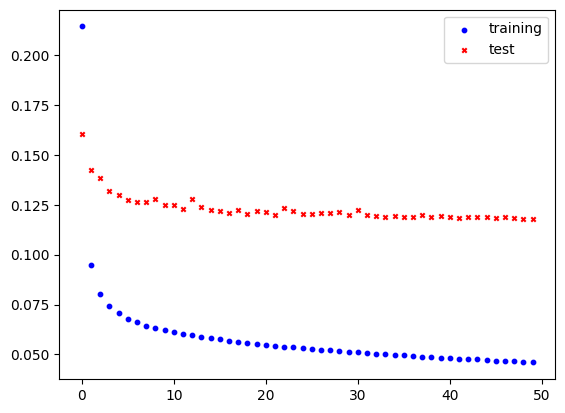

In [17]:
# !!!, parar en 25 por overfitting.
modelo_raw = create_mlp(features = features, multiples = multiples, dropout = 0.5, name='raw_features_mlp_cs')


modelo_raw.compile(loss='log_cosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.legacy.Adamax(beta_1=0.9, beta_2=0.999, lr=1e-3, decay=1e-8,))

saveas = 'raw_features_model'

modelCheckpoint=tf.keras.callbacks.ModelCheckpoint(str(saveas)+'.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = tf.keras.callbacks.History()
data = modelo_raw.fit(hftraval,ytraval, validation_data=(hftest,ytest), epochs=epochs,batch_size=batch_size, callbacks=[modelCheckpoint,history],shuffle=True, verbose=verbose)

loss_log = data.history['loss']
val_loss_log = data.history['val_loss']
mat = np.vstack((loss_log, val_loss_log)).T
dataframe1 = pd.DataFrame(data=mat)
dataframe1.to_csv(str(saveas)+'.csv', sep=',', header=False, float_format='%.7f', index=False)

plt.figure()
plt.scatter(np.arange(mat.shape[0]), mat[:,0], color = 'blue', marker='o', label='training', s=10)
plt.scatter(np.arange(mat.shape[0]), mat[:,1], color = 'red', marker='x', label='test', s=10)
plt.legend(loc='best')
plt.show()

In [14]:
modelo_raw = tf.keras.models.load_model('./raw_features_model.h5')


Now lets test our model with each crystal system

In order to archieve this, we have to divide our hftest and ytest by crystal system and then predict and plot them

In [ ]:
crystalsys = {}

for i in range(7):
    system = [dbtest.cs.values == i]
    system = np.array(system)
    system = system.reshape(15454,)
    
    crystalsys[f'system{i}'] = {'x' : hftest[system],
                                  'y': ytest[system] }

155/155 [==============================] - 2s 12ms/step


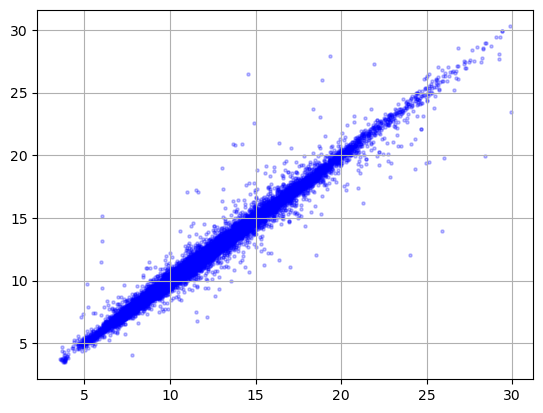

0.5646010091488065
251/251 [==============================] - 3s 12ms/step


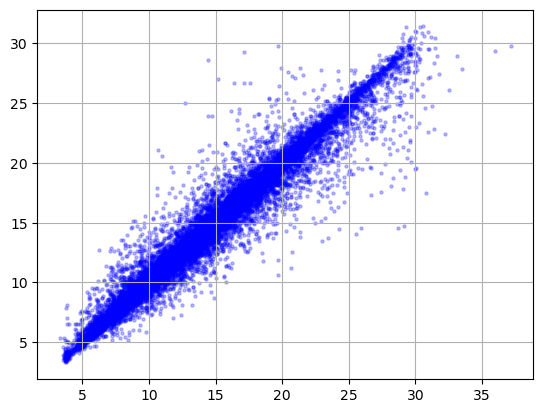

1.1299319916537358
67/67 [==============================] - 1s 12ms/step


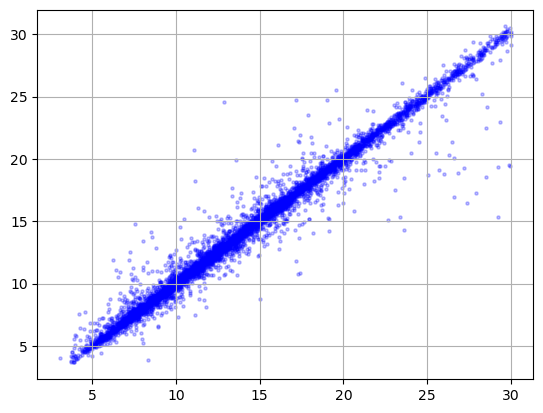

0.9257963610833723
7/7 [==============================] - 0s 12ms/step


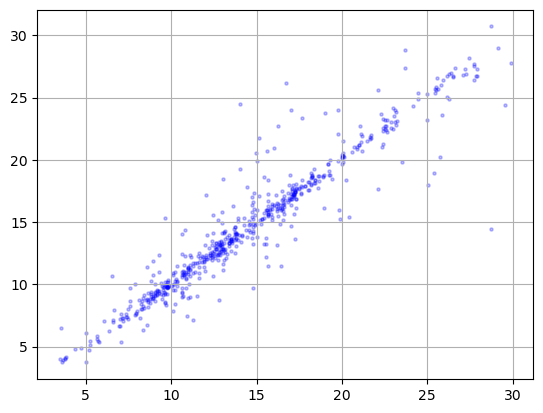

1.6939570682684069
4/4 [==============================] - 0s 10ms/step


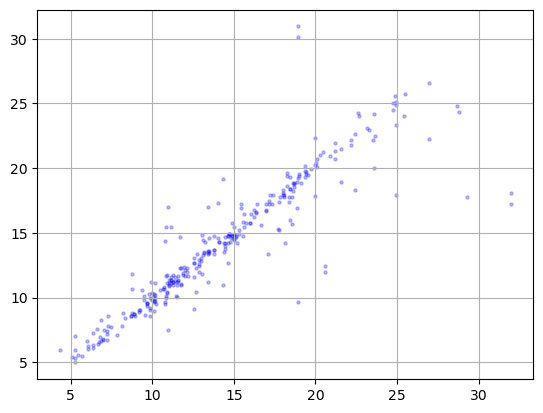

2.2705234943915924
2/2 [==============================] - 0s 13ms/step


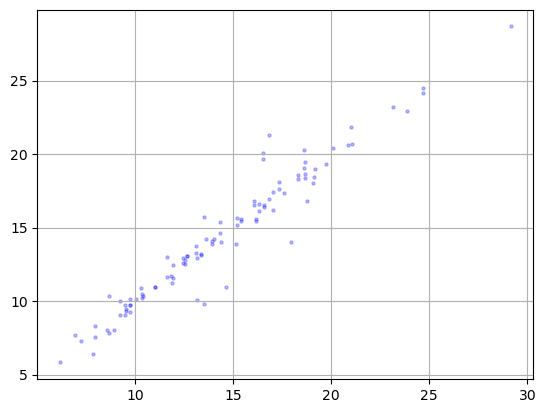

1.150668965768637
1/1 [==============================] - 0s 62ms/step


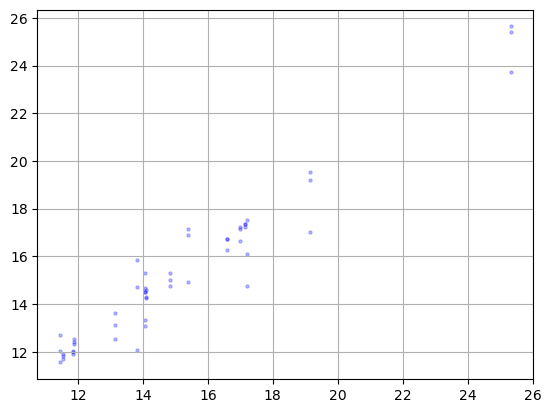

0.8466367382734964


In [20]:
for i in range(7):
    
    ptestnn = modelo_raw.predict(crystalsys[f'system{i}']['x'])
    
    plt.figure()
    plt.scatter(crystalsys[f'system{i}']['y'][:,:3], ptestnn[:,:3], s=5, color='blue', alpha=0.25)
    plt.grid()
    plt.show()
    
    rmse = ((ptestnn[:,:3] - crystalsys[f'system{i}']['y'][:,:3])**2).mean()**0.5
    print(rmse)

## 2.-Model with orthonormal vectors (raw features + crystal systems)

In [14]:
rctest = np.concatenate((hftest, csos_test), axis=-1)
rctraval = np.concatenate((hftraval, csos_traval), axis=-1)

In [15]:
features = rctraval.shape[-1]

In [17]:
modelo_cs = create_mlp(features = features, multiples = multiples, dropout = 0.5, name='rawncrys_mlp_cs')


modelo_cs.compile(loss='log_cosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.legacy.Adamax(beta_1=0.9, beta_2=0.999, lr=1e-3, decay=1e-8,))

modelCheckpoint=tf.keras.callbacks.ModelCheckpoint('rawncrys_model.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = tf.keras.callbacks.History()
data = modelo_cs.fit(rctraval,ytraval, validation_data=(rctest,ytest), epochs=25,batch_size=batch_size, callbacks=[modelCheckpoint,history],shuffle=True, verbose=verbose)

plt.figure()
plt.scatter(np.arange(mat.shape[0]), mat[:,0], color = 'blue', marker='o', label='training', s=10)
plt.scatter(np.arange(mat.shape[0]), mat[:,1], color = 'red', marker='x', label='test', s=10)
plt.legend(loc='best')
plt.show()

C:\Users\lmich\anaconda3\Lib\site-packages\keras\src\optimizers\legacy\adamax.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/25


3209/3209 [==============================] - ETA: 0s - loss: 0.2133 - mean_squared_error: 0.7547

C:\Users\lmich\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3209/3209 [==============================] - 305s 95ms/step - loss: 0.2133 - mean_squared_error: 0.7547 - val_loss: 0.1616 - val_mean_squared_error: 0.5876
Epoch 2/25
3209/3209 [==============================] - 303s 94ms/step - loss: 0.0923 - mean_squared_error: 0.2288 - val_loss: 0.1404 - val_mean_squared_error: 0.5311
Epoch 3/25
3209/3209 [==============================] - 303s 94ms/step - loss: 0.0787 - mean_squared_error: 0.1909 - val_loss: 0.1372 - val_mean_squared_error: 0.5265
Epoch 4/25
3209/3209 [==============================] - 301s 94ms/step - loss: 0.0726 - mean_squared_error: 0.1749 - val_loss: 0.1374 - val_mean_squared_error: 0.5202
Epoch 5/25
3209/3209 [==============================] - 302s 94ms/step - loss: 0.0690 - mean_squared_error: 0.1654 - val_loss: 0.1309 - val_mean_squared_error: 0.5102
Epoch 6/25
3209/3209 [==============================] - 302s 94ms/step - loss: 0.0666 - mean_squared_error: 0.1591 - val_loss: 0.1299 - val_mean_squared_error: 0.5078
Epoch 7/2

NameError: name 'saveas' is not defined

In [16]:
modelo_cs = tf.keras.models.load_model('./rawncrys_model.h5')

metrics by crystal system

In [19]:
crystalsys = {}

for i in range(7):
    system = [dbtest.cs.values == i]
    system = np.array(system)
    system = system.reshape(15454,)
    
    crystalsys[f'system{i}'] = {'x' : rctest[system],
                                  'y': ytest[system] }

155/155 [==============================] - 2s 10ms/step


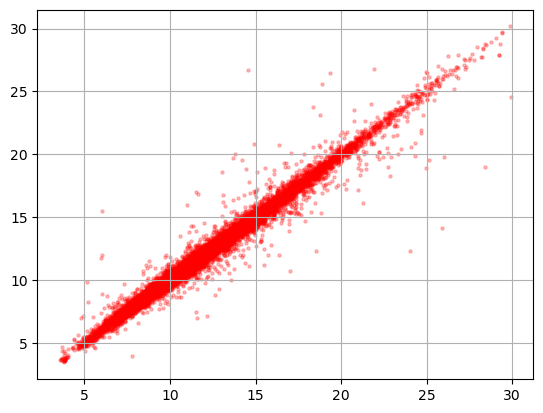

0.5476330528729467
251/251 [==============================] - 3s 10ms/step


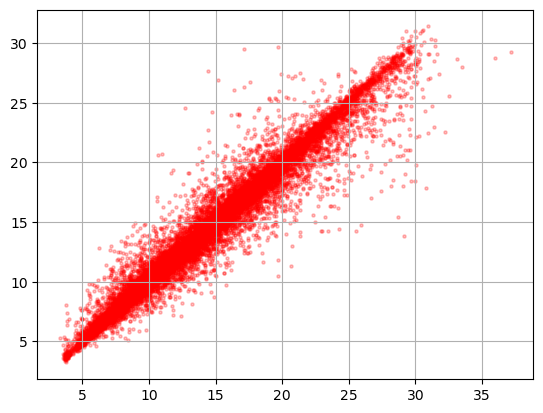

1.12146041739477
67/67 [==============================] - 1s 10ms/step


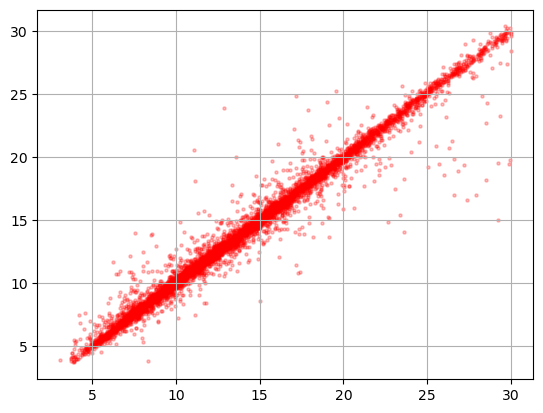

0.909061924508597
7/7 [==============================] - 0s 11ms/step


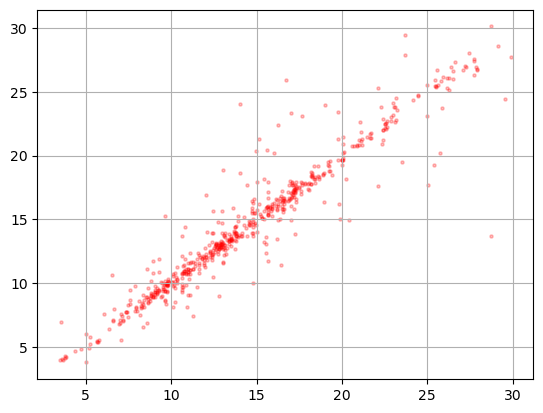

1.6342886394123912
4/4 [==============================] - 0s 11ms/step


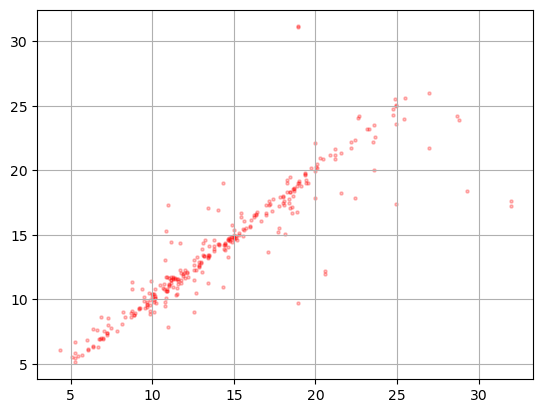

2.2746576320753458
2/2 [==============================] - 0s 18ms/step


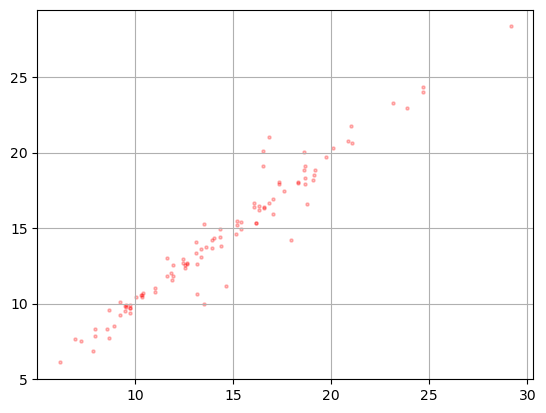

1.0613462870804704
1/1 [==============================] - 0s 37ms/step


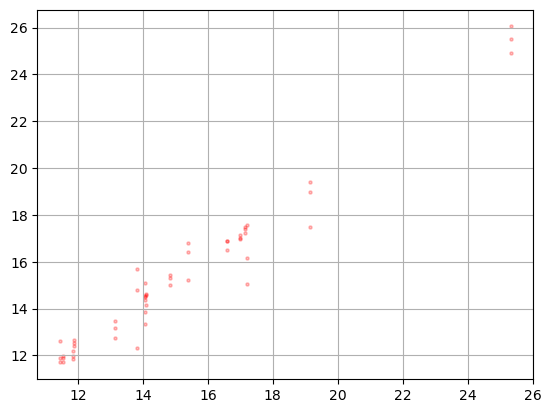

0.7208449479022528


In [20]:
for i in range(7):
    
    ptestnn = modelo_cs.predict(crystalsys[f'system{i}']['x'])
    
    plt.figure()
    plt.scatter(crystalsys[f'system{i}']['y'][:,:3], ptestnn[:,:3], s=5, color='red', alpha=0.25)
    plt.grid()
    plt.show()
    
    rmse = ((ptestnn[:,:3] - crystalsys[f'system{i}']['y'][:,:3])**2).mean()**0.5
    print(rmse)

## 3.- Model space groups (raw features + space_groups)

In [15]:
spgtest = np.concatenate((hftest, sgos_test), axis=-1)
spgtraval = np.concatenate((hftraval, sgos_traval), axis=-1)

In [16]:
features = spgtraval.shape[-1]

In [19]:
modelo_sg = create_mlp(features = features, multiples = multiples, dropout = 0.5, name='sg_mlp')

modelo_sg.compile(loss='log_cosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.legacy.Adamax(beta_1=0.9, beta_2=0.999, lr=1e-3, decay=1e-8,))

epochs = 25
batch_size = 64
verbose=1
saveas = 'rawnspg_model'

modelCheckpoint=tf.keras.callbacks.ModelCheckpoint(str(saveas)+'.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = tf.keras.callbacks.History()
data = modelo_sg.fit(spgtraval,ytraval, validation_data=(spgtest,ytest), epochs=epochs,batch_size=batch_size, callbacks=[modelCheckpoint,history],shuffle=True, verbose=verbose)


Epoch 1/25
3209/3209 [==============================] - ETA: 0s - loss: 0.2211 - mean_squared_error: 0.9955

C:\Users\lmich\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3209/3209 [==============================] - 480s 149ms/step - loss: 0.2211 - mean_squared_error: 0.9955 - val_loss: 0.1606 - val_mean_squared_error: 0.5806
Epoch 2/25
3209/3209 [==============================] - 475s 148ms/step - loss: 0.0888 - mean_squared_error: 0.2190 - val_loss: 0.1436 - val_mean_squared_error: 0.5320
Epoch 3/25
3209/3209 [==============================] - 474s 148ms/step - loss: 0.0748 - mean_squared_error: 0.1806 - val_loss: 0.1389 - val_mean_squared_error: 0.5247
Epoch 4/25
3209/3209 [==============================] - 477s 149ms/step - loss: 0.0685 - mean_squared_error: 0.1644 - val_loss: 0.1315 - val_mean_squared_error: 0.5031
Epoch 5/25
3209/3209 [==============================] - 476s 148ms/step - loss: 0.0649 - mean_squared_error: 0.1547 - val_loss: 0.1283 - val_mean_squared_error: 0.4955
Epoch 6/25
3209/3209 [==============================] - 477s 149ms/step - loss: 0.0623 - mean_squared_error: 0.1482 - val_loss: 0.1280 - val_mean_squared_error: 0.4962
Epo

In [20]:
modelo_sg = tf.keras.models.load_model('./rawnspg_model.h5')

Metrics by system

In [23]:

crystalsys = {}

for i in range(7):
    system = [dbtest.cs.values == i]
    system = np.array(system)
    system = system.reshape(15454,)
    
    crystalsys[f'system{i}'] = {'x' : spgtest[system],
                                  'y': ytest[system] }

155/155 [==============================] - 3s 17ms/step


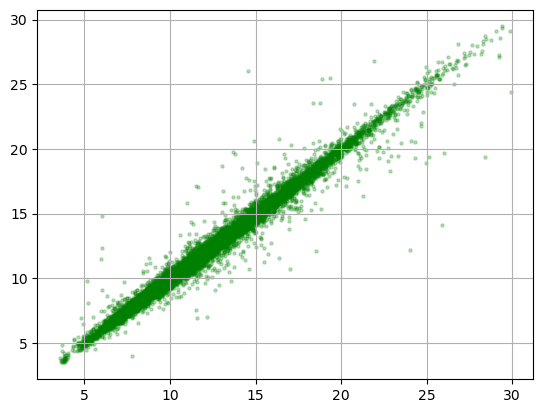

0.5450071851321013
251/251 [==============================] - 4s 17ms/step


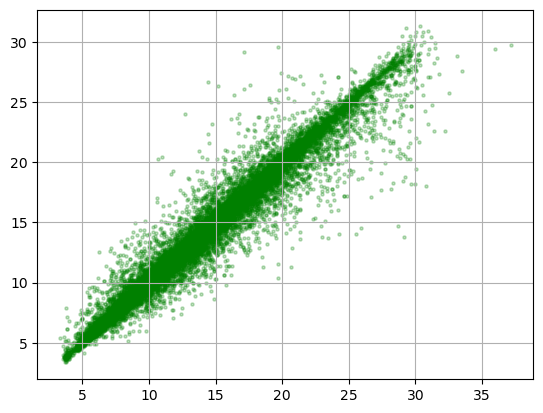

1.117415692601908
67/67 [==============================] - 1s 16ms/step


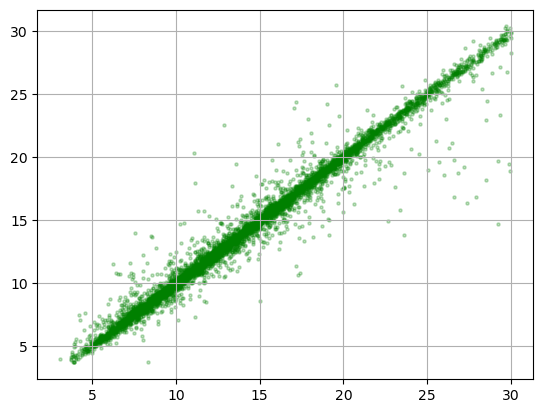

0.9025790179488311
7/7 [==============================] - 0s 20ms/step


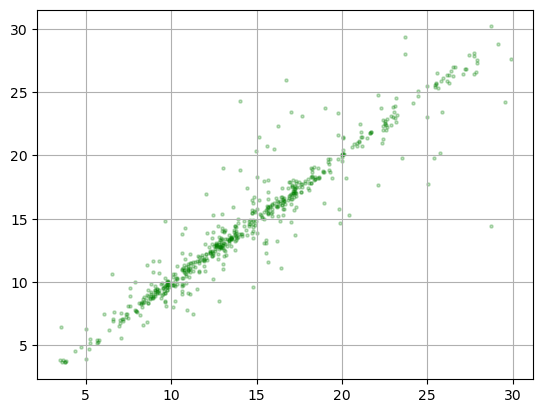

1.6330291967121566
4/4 [==============================] - 0s 18ms/step


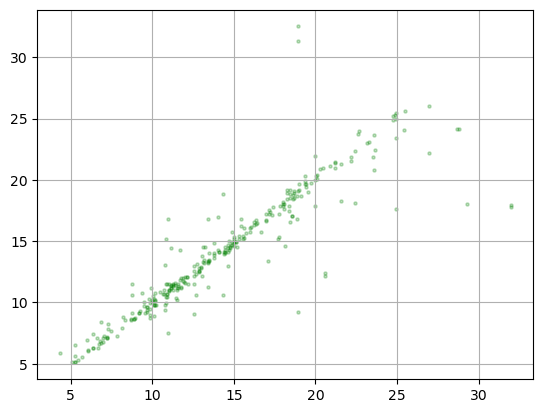

2.2729498001114363
2/2 [==============================] - 0s 36ms/step


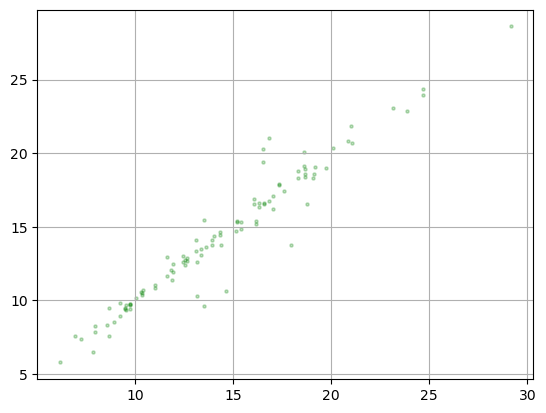

1.1332522163299954
1/1 [==============================] - 0s 37ms/step


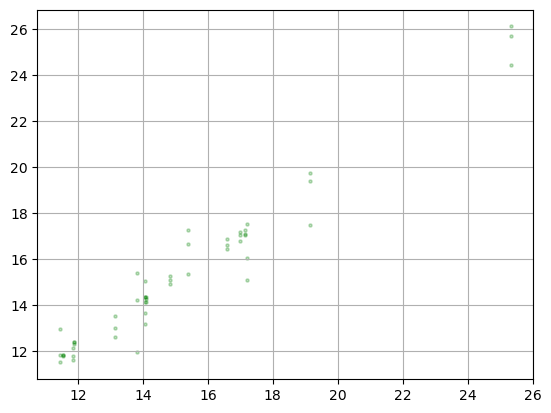

0.7491228863723262


In [24]:
for i in range(7):
    
    ptestnn = modelo_sg.predict(crystalsys[f'system{i}']['x'])
    
    plt.figure()
    plt.scatter(crystalsys[f'system{i}']['y'][:,:3], ptestnn[:,:3], s=5, color='green', alpha=0.25)
    plt.grid()
    plt.show()
    
    rmse = ((ptestnn[:,:3] - crystalsys[f'system{i}']['y'][:,:3])**2).mean()**0.5
    print(rmse)

## 4.- By difractogram features (models extension woxrd)

In [14]:
wotest = hftest[:,:-96]
wotraval = hftraval[:,:-96]

In [15]:
features = wotraval.shape[-1]

In [16]:
multiples = [6,8]

epochs = 25
batch_size = 64
verbose=1

In [17]:
modelo_wo = create_mlp(features = features, multiples = multiples, dropout = 0.5, name='difracto_wo_mlp')


modelo_wo.compile(loss='log_cosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.legacy.Adamax(beta_1=0.9, beta_2=0.999, lr=1e-3, decay=1e-8,))

saveas = 'difracto_wo_mlp'

modelCheckpoint=tf.keras.callbacks.ModelCheckpoint(str(saveas)+'.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = tf.keras.callbacks.History()
data = modelo_wo.fit(wotraval,ytraval, validation_data=(wotest,ytest), epochs=epochs,batch_size=batch_size, callbacks=[modelCheckpoint,history],shuffle=True, verbose=verbose)

plt.figure()
plt.scatter(np.arange(mat.shape[0]), mat[:,0], color = 'blue', marker='o', label='training', s=10)
plt.scatter(np.arange(mat.shape[0]), mat[:,1], color = 'red', marker='x', label='test', s=10)
plt.legend(loc='best')
plt.show()

C:\Users\marit\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adamax.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/25
3209/3209 [==============================] - 418s 130ms/step - loss: 0.5783 - mean_squared_error: 2.9307 - val_loss: 0.5483 - val_mean_squared_error: 3.2916
Epoch 2/25
3209/3209 [==============================] - 411s 128ms/step - loss: 0.4415 - mean_squared_error: 2.3099 - val_loss: 0.5208 - val_mean_squared_error: 3.1371
Epoch 3/25
3209/3209 [==============================] - 400s 125ms/step - loss: 0.4151 - mean_squared_error: 2.1867 - val_loss: 0.5114 - val_mean_squared_error: 3.1416
Epoch 4/25
3209/3209 [==============================] - 400s 125ms/step - loss: 0.3987 - mean_squared_error: 2.1014 - val_loss: 0.5170 - val_mean_squared_error: 3.2634
Epoch 5/25
3209/3209 [==============================] - 398s 124ms/step - loss: 0.3890 - mean_squared_error: 2.0497 - val_loss: 0.5040 - val_mean_squared_error: 3.1723
Epoch 6/25
3209/3209 [==============================] - 413s 129ms/step - loss: 0.3807 - mean_squared_error: 2.0012 - val_loss: 0.5018 - val_mean_squared_error:

NameError: name 'mat' is not defined

<Figure size 640x480 with 0 Axes>

In [18]:
modelo_wo = tf.keras.models.load_model('C:/Users/marit/Documents/UPY Estancia I/difracto_wo_mlp.h5')

In [19]:
hftest.shape

(15454, 480)

metrics by crystal system

In [20]:
crystalsys = {}

for i in range(7):
    system = [dbtest.cs.values == i]
    system = np.array(system)
    system = system.reshape(15454,)
    
    crystalsys[f'system{i}'] = {'x' : wotest[system],
                                  'y': ytest[system] }

155/155 [==============================] - 4s 25ms/step


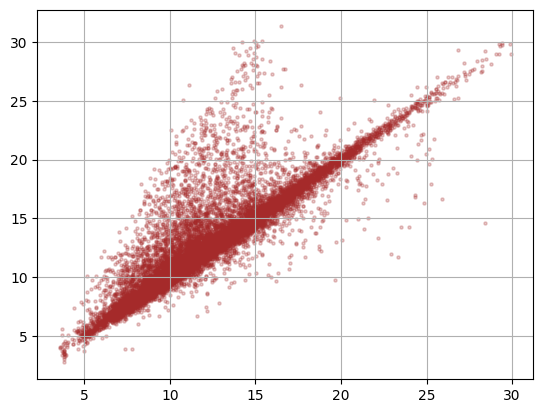

2.0923392919053274
251/251 [==============================] - 7s 27ms/step


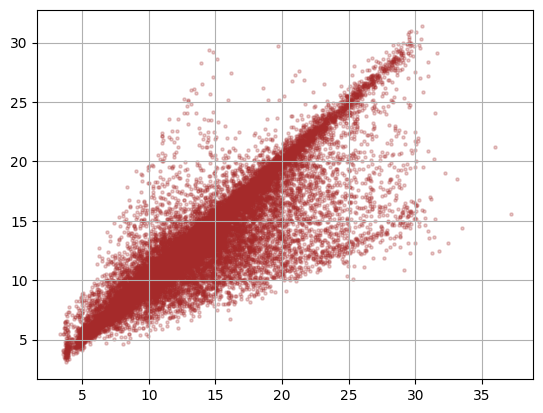

2.8106494378861537
67/67 [==============================] - 2s 26ms/step


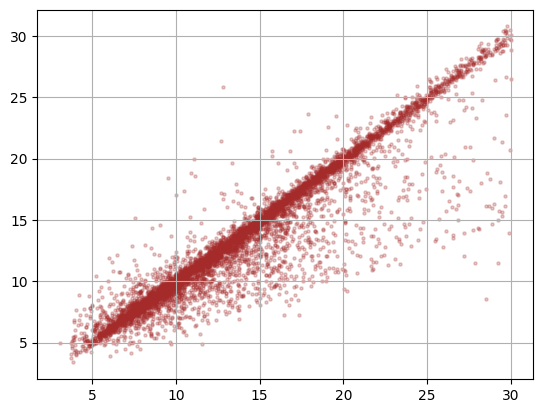

2.1452621235189135
7/7 [==============================] - 0s 24ms/step


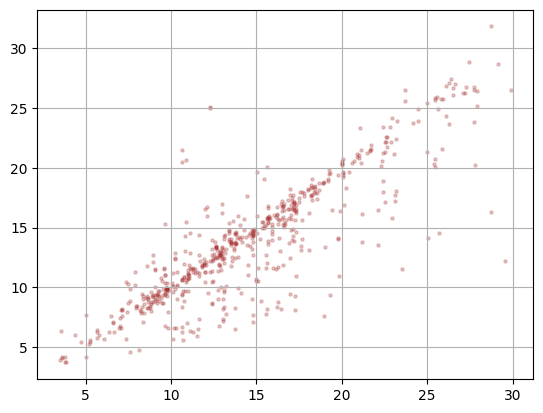

2.8807422708887165
4/4 [==============================] - 0s 24ms/step


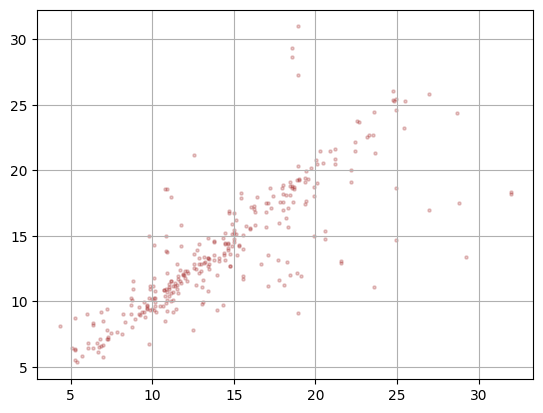

3.172832399659681
2/2 [==============================] - 0s 12ms/step


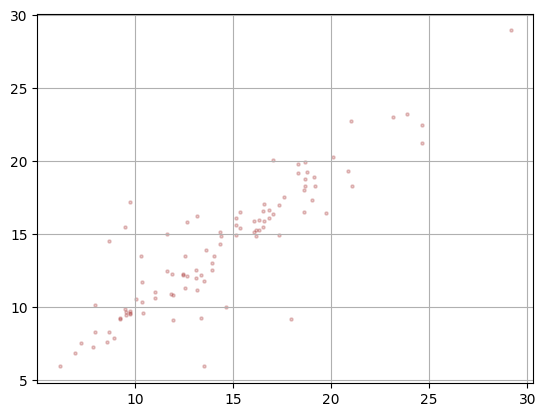

2.1513512546514293
1/1 [==============================] - 0s 53ms/step


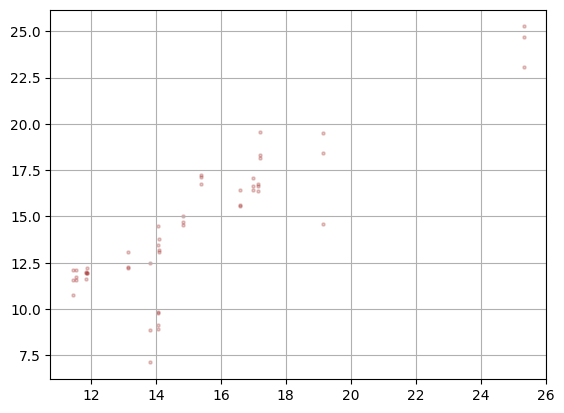

2.030794035018557


In [21]:
for i in range(7):
    
    ptestnn = modelo_wo.predict(crystalsys[f'system{i}']['x'])
    
    plt.figure()
    plt.scatter(crystalsys[f'system{i}']['y'][:,:3], ptestnn[:,:3], s=5, color='brown', alpha=0.25)
    plt.grid()
    plt.show()
    
    rmse = ((ptestnn[:,:3] - crystalsys[f'system{i}']['y'][:,:3])**2).mean()**0.5
    print(rmse)

## 5.-difracto by space groups

In [22]:
spgtest = np.concatenate((wotest, sgos_test), axis=-1)
spgtraval = np.concatenate((wotraval, sgos_traval), axis=-1)

In [23]:
features = spgtraval.shape[-1]

In [25]:
modelo_sgwo = create_mlp(features = features, multiples = multiples, dropout = 0.5, name='sg_mlp')

modelo_sgwo.compile(loss='logcosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.legacy.Adamax(beta_1=0.9, beta_2=0.999, lr=1e-3, decay=1e-8,))

epochs = 25
batch_size = 64
verbose=1
saveas = 'space_woxrd'

modelCheckpoint=tf.keras.callbacks.ModelCheckpoint(str(saveas)+'.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = tf.keras.callbacks.History()
data = modelo_sgwo.fit(spgtraval,ytraval, validation_data=(spgtest,ytest), epochs=epochs,batch_size=batch_size, callbacks=[modelCheckpoint,history],shuffle=True, verbose=verbose)


Epoch 1/25
3209/3209 [==============================] - 880s 274ms/step - loss: 0.3796 - mean_squared_error: 1.5937 - val_loss: 0.2866 - val_mean_squared_error: 1.1690
Epoch 2/25
3209/3209 [==============================] - 878s 274ms/step - loss: 0.2160 - mean_squared_error: 0.7615 - val_loss: 0.2608 - val_mean_squared_error: 1.0508
Epoch 3/25
3209/3209 [==============================] - 878s 274ms/step - loss: 0.1862 - mean_squared_error: 0.6412 - val_loss: 0.2305 - val_mean_squared_error: 0.9829
Epoch 4/25
3209/3209 [==============================] - 879s 274ms/step - loss: 0.1715 - mean_squared_error: 0.5859 - val_loss: 0.2211 - val_mean_squared_error: 0.9377
Epoch 5/25
3209/3209 [==============================] - 877s 273ms/step - loss: 0.1626 - mean_squared_error: 0.5527 - val_loss: 0.2202 - val_mean_squared_error: 0.9269
Epoch 6/25
3209/3209 [==============================] - 871s 271ms/step - loss: 0.1563 - mean_squared_error: 0.5297 - val_loss: 0.2141 - val_mean_squared_error:

KeyboardInterrupt: 

In [ ]:
modelo_sgwo = tf.keras.models.load_model('C:/Users/marit/Documents/UPY Estancia I/space_woxrd.h5')

In [ ]:
crystalsys = {}

for i in range(7):
    system = [dbtest.cs.values == i]
    system = np.array(system)
    system = system.reshape(15454,)
    
    crystalsys[f'system{i}'] = {'x' : spgtest[system],
                                  'y': ytest[system] }
    
for i in range(7):
    
    ptestnn = modelo_sgwo.predict(crystalsys[f'system{i}']['x'])
    
    plt.figure()
    plt.scatter(crystalsys[f'system{i}']['y'][:,:3], ptestnn[:,:3], s=5, color='darkolivegreen', alpha=0.25)
    plt.grid()
    plt.show()
    
    rmse = ((ptestnn[:,:3] - crystalsys[f'system{i}']['y'][:,:3])**2).mean()**0.5
    print(rmse)

## 6.- By crystal systems and difractograms

In [ ]:
rctest = np.concatenate((wotest, csos_test), axis=-1)
rctraval = np.concatenate((wotraval, csos_traval), axis=-1)

In [ ]:
features = rctraval.shape[-1]

In [ ]:
modelo_cswo = create_mlp(features = features, multiples = multiples, dropout = 0.5, name='cs_mlp')

modelo_cswo.compile(loss='log_cosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.legacy.Adamax(beta_1=0.9, beta_2=0.999, lr=1e-3, decay=1e-8,))

epochs = 25
batch_size = 64
verbose=1
saveas = 'crystal_wo_mlp'

modelCheckpoint=tf.keras.callbacks.ModelCheckpoint(str(saveas)+'.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = tf.keras.callbacks.History()
data = modelo_cswo.fit(rctraval,ytraval, validation_data=(rctest,ytest), epochs=epochs,batch_size=batch_size, callbacks=[modelCheckpoint,history],shuffle=True, verbose=verbose)

loss_log = data.history['loss']
val_loss_log = data.history['val_loss']
mat = np.vstack((loss_log, val_loss_log)).T
dataframe1 = pd.DataFrame(data=mat)
dataframe1.to_csv(str(saveas)+'.csv', sep=',', header=False, float_format='%.7f', index=False)

In [ ]:
modelo_cswo = tf.keras.models.load_model('C:/Users/marit/Documents/UPY Estancia I/crystal_wo_mlp.h5')

In [ ]:
crystalsys = {}

for i in range(7):
    system = [dbtest.cs.values == i]
    system = np.array(system)
    system = system.reshape(15454,)
    
    crystalsys[f'system{i}'] = {'x' : rctest[system],
                                  'y': ytest[system] }
    
for i in range(7):
    
    ptestnn = modelo_cswo.predict(crystalsys[f'system{i}']['x'])
    
    plt.figure()
    plt.scatter(crystalsys[f'system{i}']['y'][:,:3], ptestnn[:,:3], s=5, color='crimson', alpha=0.25)
    plt.grid()
    plt.show()
    
    rmse = ((ptestnn[:,:3] - crystalsys[f'system{i}']['y'][:,:3])**2).mean()**0.5
    print(rmse)